# Nested Operator Inference

**TODO:** Add description
**TODO:** Why consider nested OpInf?
- start from smaller space
- way to update ROM

[1] Aretz, Nicole, and Karen Willcox. "Enforcing structure in data-driven reduced modeling through nested Operator Inference." In 2024 IEEE 63rd Conference on Decision and Control (CDC), pp. 8046-8053. IEEE, 2024.

[2] Aretz, Nicole, and Karen Willcox. "Nested Operator Inference for Adaptive Data-Driven Learning of Reduced-order Models." arXiv preprint arXiv:2508.11542 (2025).

[3] Qian, Elizabeth, Ionut-Gabriel Farcas, and Karen Willcox. "Reduced operator inference for nonlinear partial differential equations." SIAM Journal on Scientific Computing 44, no. 4 (2022): A1934-A1959.


## Problem Statement

We consider the cubic example from [2], section 5.1: For a heat conduction parameter $\kappa \in [0.001, 0.1]$, identiy $x(t,z)$ with
$$\dot{x}(t, z) = \kappa \Delta_z x(t, z) - x(t, z)^3, \qquad \forall t > 0, z \in (0, 1)$$
with initial condition $x(0, z) = 10z(1-z)$ and zero-Dirichlet boundary conditions $x(t, 0) = x(t, 1) = 0$ for all $t>0$. 

In [13]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import opinf

## Full-order model data
The problem is discretized using linear finite elements, and solved with Crank-Nicholson time-stepping using a step size of $\Delta t = 0.001$. 

The training and testing data used in [2] can be downloaded here. After the download, change the `path_to_data` variable below to where the data was saved.

In [2]:
path_to_data = "/storage/nicole/git-save-data/opinf/cubic-heat/paper/data/"

We load the whole data set for testing purposes.

In [3]:
# load in training and testing data
with open(path_to_data + "trainingdata", "rb") as file:
    Xi_test, U_para_test, compute_time = pickle.load(file)

nFE = U_para_test[0].shape[0] # finite element dimension
grid_t = np.arange(0, 1+0.001, 0.001) # temporal discretization

The parameter $\kappa$ does SOMETHING.

In [4]:
# todo: figure for how the parameter changes the FOM solution


For training, we only use the data from three parameters: $\kappa = 0.001$, $\kappa = 0.01$, $\kappa = 0.1$.

In [5]:
# specify what we use as training data
final_training_time = 0.2
indices_training_parameters = [0, 100, 200]

# extract training data
K_train = np.argmin(np.abs(grid_t - final_training_time)) + 1
n_para = len(indices_training_parameters)
Xi_train = Xi_test[indices_training_parameters, :] # training parameters
U_para = U_para_test[indices_training_parameters] # training snapshots
print("Training parameters:", Xi_train[:, 0])

# only use data up to end of training time
for i in range(n_para):
    U_para[i] = U_para[i][:, :K_train]

Training parameters: [0.001 0.01  0.1  ]


## Reduced basis

We build a reduced space using the training data. First, we scale the data. We do not center it because that would introduce constant and quadratic terms for additional degrees of freedom we would need to learn.

In [6]:
# stack the training data next to each other, the transformer doesn't know about the parameterization
U_stacked = np.hstack(U_para)

# initialize the transformer
transformer = opinf.pre.ShiftScaleTransformer(centering = False, scaling = 'maxnorm', verbose = True)
U_transformed = transformer.fit_transform(U_stacked)

# apply the transformation individually to the data for each parameter
U_train = [transformer.transform(u) for u in U_para]

Learned maxnorm scaling Q -> Q''
    |     min    |    mean    |     max    |    std
----|------------|------------|------------|------------
Q   |  0.000e+00 |  1.235e+00 |  2.500e+00 |  5.424e-01
Q'' |  0.000e+00 |  2.139e-02 |  4.330e-02 |  9.395e-03



Second, we compute the singular value decay of the transformed data. We use the method of snapshots with the mass of the finite element discretization as inner product matrix. Doing so follows the analysis in [3] about Operator Inference for partial differential equations. When the mass matrix is not available, we can use the identity matrix instead as an approximation. Because the problem is already discretized, the Euclidean norm of the finite element coefficients is equivalent to the $L^2((0,1))$ norm of their encoded function.

In [7]:
# comment in next part to treat mass matrix as unknown
from scipy.sparse import eye
mass_matrix = eye(nFE)

# use method of snapshots
VR, svdvals, __ = opinf.basis.method_of_snapshots(states=U_transformed, inner_product_matrix=mass_matrix, minthresh=0)

Third, we look at the singular value decay to choose the reduced dimension:

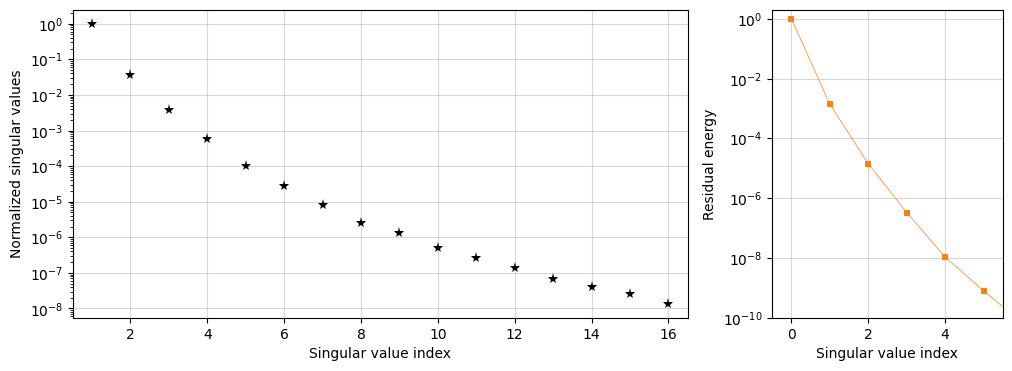

In [20]:
# plots of singular values and residual energy
fig, axs = plt.subplots(1, 2, figsize=(12, 4), width_ratios=[16, 6])

# left plot: singluar value decay
opinf.basis.svdval_decay(svdvals, threshold=[], ax=axs[0])
axs[0].grid(True, alpha=0.5)
axs[0].set_xlim(0.5, 16.5)

# right plot: residual energy (NOT in percent)
opinf.basis.residual_energy(svdvals, threshold=[], ax=axs[1])
axs[1].set_ylim(1e-10, 2)
axs[1].set_xlim(-0.5, 5.5)
axs[1].grid(True, alpha=0.5)

Here, we follow [2] and choose the reduced dimension `nRB = 5`. The singular values and residual energy depend on whether the finite element mass matrix was used during the method of snapshots. The residual energy for $r=5$ is very small, for both inner product matrices. A small residual energy means that the training snapshots can be approximated well in the chosen reduced space. However, a larger dimension also leads to a larger number of degrees of freedom in the OpInf learning problem, which makes overfitting more likely. In view of this, and because additional POD basis vectors are increasingly less important, it can be benefitial for classic OpInf to accept a larger residual energy to get a smaller reduced dimension. However, nested OpInf suffers less from these issues because the POD hierarchy is respected during construction. Choosing $r=5$ is thus perfectly fine.

In [22]:
nRB = 5
VR = VR[:, :nRB]

## Operator Inference

We need to learn a linear-cubic model. For each test function, we have $r + \frac{r(r-1)(r-2)}{6}$ degrees of freedom.

In [30]:
linear_operator = opinf.operators.AffineLinearOperator(coeffs=1)
cubic_operator = opinf.operators.CubicOperator()

for n in range(1, nRB+1):
    print(f"r = {n}: number of unknowns {linear_operator.operator_dimension(s=1, r=n, m=None) + cubic_operator.operator_dimension(r=n, m=None)}")

r = 1: number of unknowns 2
r = 2: number of unknowns 6
r = 3: number of unknowns 13
r = 4: number of unknowns 24
r = 5: number of unknowns 40


### Helper functions

### Classic Approach

### Nested Operator Inference

## Comparison

## The End.